In [4]:
# FMNIST 파일 학습하고 예측하기!

In [5]:
import torch # Dataset에 넣어줄 torch 모듈을 임포트
import torch.nn as nn
# nn은 neural network의 약자 
# 다양한 종류의 레이어, 손실 함수, 활성화함수를 갖고있음
from torch.utils.data import DataLoader, Dataset
# Dataset, DataLoader 함수로서 Dataset을 불러 올수 있게함
from torchvision import datasets, transforms

import os

import matplotlib.pyplot as plt

# device 설정 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# cuda를 이용가능하면 장치를 'cuda'를 이용하고 아니면 'cpu를 사용한다'


In [9]:
# Dataset 폴더 생성
test_data_dict='test_dataset'
os.makedirs(test_data_dict,exist_ok=True) # 'test_dataset'이란 디렉토리를 생성한다

# Dataset 생성 (train set),(test set)
train_set=datasets.FashionMNIST(root=test_data_dict, # test_data_dict에 저장하겠다
                      train=True, # train data를 저장 할거고 
                      download=True, # 없으면 다운로드 할것
                      transform=transforms.ToTensor(), # tensor타입으로 저장할 것
                     )
test_set=datasets.FashionMNIST(root=test_data_dict, # test_data_dict에 저장하겠다
                      train=False, # train data를 저장 할거고 
                      download=True, # 없으면 다운로드 할것
                      transform=transforms.ToTensor() # tensor타입으로 저장할 것
                     )

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:04<00:00, 5524643.43it/s]


Extracting test_dataset\FashionMNIST\raw\train-images-idx3-ubyte.gz to test_dataset\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 107741.32it/s]


Extracting test_dataset\FashionMNIST\raw\train-labels-idx1-ubyte.gz to test_dataset\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1691213.82it/s]


Extracting test_dataset\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to test_dataset\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5161911.78it/s]

Extracting test_dataset\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to test_dataset\FashionMNIST\raw



In [81]:
print(len(train_set)) # 데이터의 갯수
print(len(test_set))
print((train_set[0][0]).shape)  # 이미지 하나의  shape 1개의 차원, 28,28사이즈를 갖고있음.

60000
10000
torch.Size([1, 28, 28])


In [13]:
sample=train_set[0] # train_set[0]은 tensor 형태에 image와 lable 값을 가지고 있음 

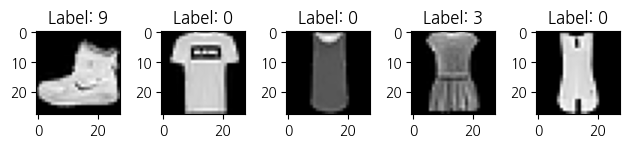

In [53]:
# train_set의형태
# 아직 라벨과 분리하지 않음 
for i in range(5):
    plt.subplot(1,5,i+1)
    # subplot(행 , 열, index) 각 index에 넣어준다
    plt.imshow(train_set[i][0].squeeze(), cmap='gray') 
    plt.title(f"Label: {train_set[i][1]}")
plt.tight_layout()
plt.show()

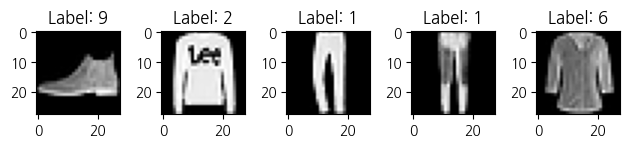

In [72]:
# test_set의 형태
# 아직 라벨과 분리하지 않음
for i in range(5):
    plt.subplot(1,5,i+1)
    # subplot(행 , 열, index) 각 index에 넣어준다
    plt.imshow(test_set[i][0].squeeze(), cmap='gray') 
    plt.title(f"Label: {test_set[i][1]}")
plt.tight_layout()
plt.show()

# DataLoader 로 Dataset을 넣어준다
-  DataLoader: 모델에 Dataset을 넣어주고 너무 많이 넣으면 위험하니 batch_size를 넣어서 data학습 숫자를 정해준다.

In [73]:
# 파라미터를 넣어준다
BATCH_SIZE=256
train_loader=DataLoader(train_set, # Dataset 을 넣어줌
                        batch_size=BATCH_SIZE,
                        shuffle=True, # 학습시, 1에폭이 끝나면 랜덤하게 값을 학습할수 있게 해준다..
                        drop_last = True # 마지막 배치의 개수가 batch_size보다 적으면 학습안하고 넘긴다.
                       )
test_loader=DataLoader(test_set,
                      batch_size=BATCH_SIZE
                      )
# drop_last 를 주는 이유 256개를 해야하는데 90개만 남으면 마지막 배치를 학습할때 90개는 256개를 학습시킨것에서 과적합이 일어날수 있다
# 그래서 버리고 shuffle에서 다시 랜덤값으로 들어갈수 있으니 넘어가게 한다!

In [79]:
len(train_loader)
len(test_loader)

40

In [80]:
# train의 1에폭당 step 수 
60000/256 # 1에폭당 step수 256이 234번 밟아야 60000개을 밞을수 있다.
10000/256# 1 에폭당 step수 256dl 40번 밟아야 10000개를 다 밟을수 있다.

39.0625

# 네트워크 모델 생성

In [123]:
import torch.nn as nn
class FMNIST_Model(nn.Module):
    
    def __init__(self):
        super().__init__() # Module의 상속받음
        self.lr1 = nn.Linear(28*28,256) # (입력 데이터,출력 데이터)
        self.lr2 = nn.Linear(256,128) # (lr1의 출력 데이터, lr2의 출력 데이터)
        self.lr3 = nn.Linear(128,64) # (lr2의 출력 데이터, lr3의 출력 데이터)
        self.lr4 = nn.Linear(64,32) # (lr3의 출력 데이터, lr4의 출력 데이터)
        self.lr5 = nn.Linear(32,10) # (lr 4의 출력 데이터, output데이터)
        self.ReLU = nn.ReLU()
    def forward(self,X):
        # 입력데이터를  이곳에서 받고 순전파를 진행하게 함.
        X = torch.flatten(X, start_dim=1) # axis 1 이후의 데이터를 flatten을 만들어줌
        X = self.lr1(X) # 1차원 Data를 lr1로 넣어줌 
        X = nn.ReLU()(X) # 활성함수를 이용해 가중치를 넣어줌
        
        X = self.lr2(X) 
        X = nn.ReLU()(X)
        
        X = self.lr3(X)
        X = nn.ReLU()(X)

        X = self.lr4(X)
        X = nn.ReLU()(X)
        
        X = self.lr5(X) # 여기서 끝
        
        return X 
        
        # 
        
        

In [124]:
# 생성한 모델로 객체 생성 
FMmodel= FMNIST_Model() # 여기서 생성자(__init__()이 실행됨)

In [125]:
# 모델 구조 확인
FMmodel 

FMNIST_Model(
  (lr1): Linear(in_features=784, out_features=256, bias=True)
  (lr2): Linear(in_features=256, out_features=128, bias=True)
  (lr3): Linear(in_features=128, out_features=64, bias=True)
  (lr4): Linear(in_features=64, out_features=32, bias=True)
  (lr5): Linear(in_features=32, out_features=10, bias=True)
  (ReLU): ReLU()
)

In [126]:
from torchinfo import summary

In [132]:
summary(FMmodel,(BATCH_SIZE,784))

Layer (type:depth-idx)                   Output Shape              Param #
FMNIST_Model                             [256, 10]                 --
├─Linear: 1-1                            [256, 256]                200,960
├─Linear: 1-2                            [256, 128]                32,896
├─Linear: 1-3                            [256, 64]                 8,256
├─Linear: 1-4                            [256, 32]                 2,080
├─Linear: 1-5                            [256, 10]                 330
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
Total mult-adds (M): 62.60
Input size (MB): 0.80
Forward/backward pass size (MB): 1.00
Params size (MB): 0.98
Estimated Total Size (MB): 2.78